In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [2]:
try:
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

TensorFlow 2.x selected.


In [0]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_hub as hub
import tensorflow_datasets as tfds

from tensorflow.keras import layers

In [0]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [6]:
splits = tfds.Split.TRAIN.subsplit([70,30])
(training_set, validation_set), dataset_info = tfds.load('tf_flowers', with_info=True, as_supervised=True, split=splits)

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/1.0.0. Subsequent calls will reuse this data.


In [9]:
num_classes = dataset_info.features['label'].num_classes

num_training_examples = 0
num_validation_examples = 0

for example in training_set:
  num_training_examples += 1
for example in validation_set:
  num_validation_examples += 1

print('Total Number of Classes: {}'.format(num_classes))
print('Total Number of Training Images: {}'.format(num_training_examples))
print('Total Number of Validation Images: {} \n'.format(num_validation_examples))

Total Number of Classes: 5
Total Number of Training Images: 2590
Total Number of Validation Images: 1080 



In [11]:
for i, example in enumerate(training_set.take(5)):
  print('Image {} shape: {} label: {}'.format(i+1, example[0].shape, example[1]))

Image 1 shape: (213, 320, 3) label: 4
Image 2 shape: (322, 500, 3) label: 1
Image 3 shape: (256, 320, 3) label: 1
Image 4 shape: (240, 320, 3) label: 4
Image 5 shape: (212, 320, 3) label: 2


MobileNet v2 expects images in (224,224)

In [0]:
IMAGE_RES = 224

def format_image(image, label):
  # resize and normalize images
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
  return image, label

BATCH_SIZE = 32
# creation of training and validation batches of size 32
train_batches = training_set.shuffle(num_training_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_set.map(format_image).batch(BATCH_SIZE).prefetch(1)

In [0]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor = hub.KerasLayer(URL, input_shape=(IMAGE_RES, IMAGE_RES, 3))

Freeze the variables in the feature extractor layer, so that the training only modifies the final classifier layer

In [0]:
feature_extractor.trainable = False

Attaching a classification head

In [17]:
model = tf.keras.Sequential([
                             feature_extractor,
                             layers.Dense(num_classes, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


Training the model for 6 epochs

In [18]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

EPOCHS = 6

history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/6
81/81 [==============================] - 22s 266ms/step - loss: 0.7669 - accuracy: 0.7205 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/6
81/81 [==============================] - 12s 147ms/step - loss: 0.3882 - accuracy: 0.8680 - val_loss: 0.3846 - val_accuracy: 0.8778
Epoch 3/6
81/81 [==============================] - 12s 147ms/step - loss: 0.2920 - accuracy: 0.9035 - val_loss: 0.3480 - val_accuracy: 0.8944
Epoch 4/6
81/81 [==============================] - 12s 147ms/step - loss: 0.2417 - accuracy: 0.9270 - val_loss: 0.3275 - val_accuracy: 0.9037
Epoch 5/6
81/81 [==============================] - 12s 146ms/step - loss: 0.2034 - accuracy: 0.9394 - val_loss: 0.3218 - val_accuracy: 0.9009
Epoch 6/6
81/81 [==============================] - 12s 146ms/step - loss: 0.1738 - accuracy: 0.9502 - val_loss: 0.3138 - val_accuracy: 0.9009


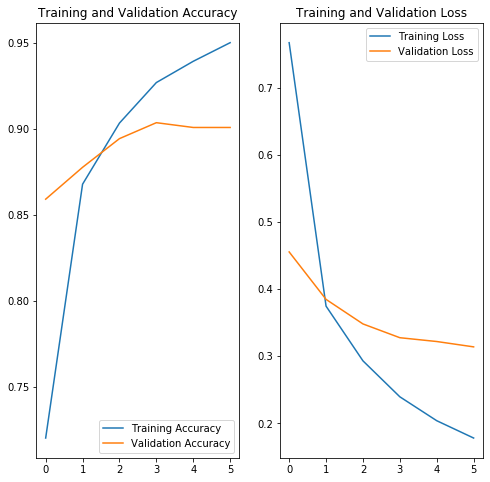

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [20]:
class_names = np.array(dataset_info.features['label'].names)

print(class_names)

['dandelion' 'daisy' 'tulips' 'sunflowers' 'roses']


Image batch creation for predictions

In [21]:
image_batch, label_batch = next(iter(train_batches))


image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()

predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]

print(predicted_class_names)

['tulips' 'roses' 'sunflowers' 'tulips' 'dandelion' 'tulips' 'roses'
 'sunflowers' 'sunflowers' 'tulips' 'tulips' 'tulips' 'tulips' 'roses'
 'daisy' 'sunflowers' 'sunflowers' 'roses' 'roses' 'dandelion'
 'sunflowers' 'sunflowers' 'tulips' 'tulips' 'dandelion' 'tulips' 'tulips'
 'roses' 'tulips' 'tulips' 'dandelion' 'daisy']


In [22]:
print("Labels:           ", label_batch)
print("Predicted labels: ", predicted_ids)

Labels:            [2 4 3 2 0 2 4 3 3 2 2 4 2 4 1 3 3 4 4 0 3 2 2 2 0 2 2 4 2 2 0 1]
Predicted labels:  [2 4 3 2 0 2 4 3 3 2 2 2 2 4 1 3 3 4 4 0 3 3 2 2 0 2 2 4 2 2 0 1]


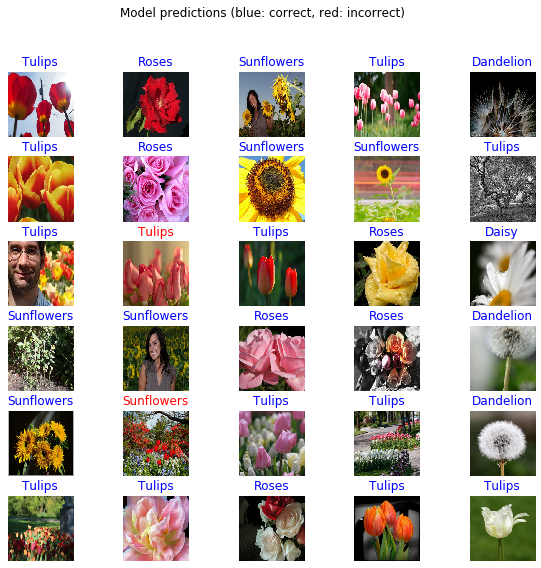

In [23]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")

Transfer Learning with Inception Model

In [24]:
IMAGE_RES = 299

(training_set, validation_set), dataset_info = tfds.load('tf_flowers', with_info=True, as_supervised=True, split=splits)
train_batches = training_set.shuffle(num_training_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_set.map(format_image).batch(BATCH_SIZE).prefetch(1)

URL = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"
feature_extractor = hub.KerasLayer(URL,
  input_shape=(IMAGE_RES, IMAGE_RES, 3),
  trainable=False)

model_inception = tf.keras.Sequential([
  feature_extractor,
  tf.keras.layers.Dense(num_classes, activation='softmax')
])

model_inception.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 2048)              21802784  
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 10245     
Total params: 21,813,029
Trainable params: 10,245
Non-trainable params: 21,802,784
_________________________________________________________________


In [25]:
model_inception.compile(
  optimizer='adam', 
  loss='sparse_categorical_crossentropy',
  metrics=['accuracy'])

EPOCHS = 6

history = model_inception.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/6
81/81 [==============================] - 47s 578ms/step - loss: 0.7783 - accuracy: 0.7143 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/6
81/81 [==============================] - 34s 424ms/step - loss: 0.3940 - accuracy: 0.8815 - val_loss: 0.3856 - val_accuracy: 0.8806
Epoch 3/6
81/81 [==============================] - 34s 425ms/step - loss: 0.2969 - accuracy: 0.9069 - val_loss: 0.3685 - val_accuracy: 0.8787
Epoch 4/6
81/81 [==============================] - 34s 423ms/step - loss: 0.2518 - accuracy: 0.9243 - val_loss: 0.3725 - val_accuracy: 0.8796
Epoch 5/6
81/81 [==============================] - 34s 424ms/step - loss: 0.2218 - accuracy: 0.9347 - val_loss: 0.3505 - val_accuracy: 0.8815
Epoch 6/6
81/81 [==============================] - 34s 423ms/step - loss: 0.1982 - accuracy: 0.9444 - val_loss: 0.3204 - val_accuracy: 0.8954


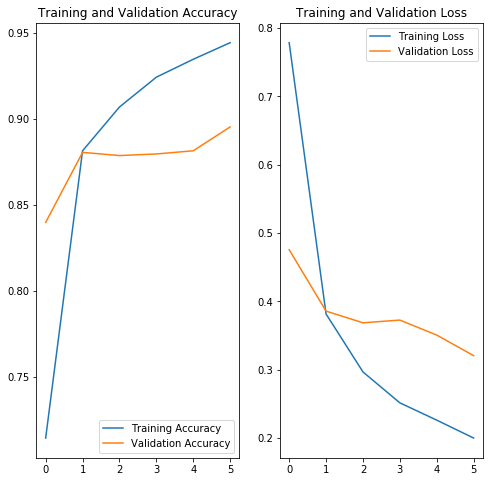

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()